In [1]:
#########################################################################
## COMPROBAR GPU ASIGNADA EN COLABORATORY
#########################################################################
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
else:
  print(gpu_info)

Fri Jan  5 18:17:16 2024       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.147.05   Driver Version: 525.147.05   CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA GeForce ...  Off  | 00000000:01:00.0  On |                  N/A |
| N/A   54C    P8    17W / 100W |   1807MiB /  6144MiB |     41%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [2]:
!pip install gymnasium

Defaulting to user installation because normal site-packages is not writeable


In [3]:
!pip install stable_baselines3

Defaulting to user installation because normal site-packages is not writeable


In [4]:
#########################################################################
## LIBRERIAS NECESARIAS
#########################################################################
import tensorflow as tf
import gymnasium as gym
from stable_baselines3 import PPO
from tensorflow.keras.layers import concatenate
import numpy as np
import keras
import matplotlib.pyplot as plt
from keras import layers
import copy
import torch
from sklearn.model_selection import train_test_split

import sys

import os
from stable_baselines3.common.vec_env import DummyVecEnv

2024-01-05 18:17:18.589277: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-01-05 18:17:18.599053: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2024-01-05 18:17:18.650720: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2024-01-05 18:17:18.651486: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-01-05 18:17:19.394851: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not fin

In [5]:
############################################################################
## Variables globales (hiperparámetros)
###########################################################################
EPOCHS=1

EPISODES=10
EPISODES_EVALUATE_G=50

TOTAL_TIMESTEPS_PPO_GENERATOR=250
LEARNING_RATE=0.001

# GYM Lunar Lander


* **Entorno**:

  Este entorno es un **problema clásico de optimización de trayectoria de un COHETE**. Según el principio del máximo de Pontryagin, es óptimo encender el motor a máxima potencia o apagarlo. Esta es la razón por la cual este entorno tiene acciones discretas: encender el motor o apagarlo.

 Existen dos versiones del entorno: discreta o continua. La plataforma de aterrizaje siempre se encuentra en las coordenadas (0,0). Las coordenadas son los primeros dos números en el vector de estado. Es posible aterrizar fuera de la plataforma de aterrizaje. El combustible es infinito, por lo que un agente puede aprender a volar y luego aterrizar en su primer intento.

* **Acciones**: tenemos cuatro acciones discretas:

  * **0**:No hacer nada
  * **1**: Encender motor de orientación izquierdo
  * **2**: Encender motor principal
  * **3**: Encender motor de orientación derecho
* **Observaciones**: es un vector de 8 dimensiones donde se almacenan las coordenadas (x,y), las velocidades lineales en x e y, su ángulo, su velocidad angular, y dos booleanos que representan si cada pata está en contacto con el suelo o no.


In [6]:
## Instalación de Box2D

In [7]:
!pip install swig

Defaulting to user installation because normal site-packages is not writeable


In [8]:
!git clone https://github.com/pybox2d/pybox2d

Clonando en 'pybox2d'...
remote: Enumerating objects: 3200, done.
remote: Counting objects: 100% (343/343), done.
remote: Compressing objects: 100% (139/139), done.
remote: Total 3200 (delta 194), reused 325 (delta 187), pack-reused 2857
Recibiendo objetos: 100% (3200/3200), 9.26 MiB | 1.67 MiB/s, listo.
Resolviendo deltas: 100% (1988/1988), listo.


In [9]:
!cd pybox2d && python setup.py build && python setup.py install

['Box2D', 'Box2D.examples', 'Box2D.tests', 'Box2D.b2', 'Box2D.examples.opencv', 'Box2D.examples.simple', 'Box2D.examples.pgu', 'Box2D.examples.backends', 'Box2D.examples.pgu.gui']
running build
running build_py
running build_ext
building 'Box2D._Box2D' extension
swigging Box2D/Box2D.i to Box2D/Box2D_wrap.cpp
swig -python -c++ -IBox2D -small -O -includeall -ignoremissing -w201 -globals b2Globals -outdir library/Box2D -keyword -w511 -D_SWIG_KWARGS -o Box2D/Box2D_wrap.cpp Box2D/Box2D.i
Box2D/Common/b2Math.h:67: Warning 302: Identifier 'b2Vec2' redefined by %extend (ignored),
Box2D/Box2D_math.i:47: Warning 302: %extend definition of 'b2Vec2'.
Box2D/Common/b2Math.h:158: Warning 302: Identifier 'b2Vec3' redefined by %extend (ignored),
Box2D/Box2D_math.i:168: Warning 302: %extend definition of 'b2Vec3'.
Box2D/Common/b2Math.h:197: Warning 302: Identifier 'b2Mat22' redefined by %extend (ignored),
Box2D/Box2D_math.i:301: Warning 302: %extend definition of 'b2Mat22'.
Box2D/Common/b2Math.h:271: Wa

In [10]:
pip install gymnasium[box2d]

Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.


In [11]:
# Definimos el entorno
env = gym.make("LunarLander-v2")

# Obtenemos el espacio de estados y acciones del entorno
ob_space=env.observation_space
ac_space=env.action_space

# Mostramos el número de acciones del entorno
print(env.action_space.n)
# Mostramos el número de observaciones del entorno
print(ob_space.shape[0])

4
8


# Discriminador

## Red neuronal del Discriminador

In [12]:
################################################################################################################################################
# Red neuronal del Discriminador
################################################################################################################################################

# Input: secuencias [s,a] reales o sintéticas, de longitud ob_space.shape[0] + ac_space.n.
# Output: probabilidad de que la secuencia sea real, valor perteneciente al intervalo [0,1]
discriminator_net=keras.Sequential(
    [
        keras.Input(shape=(None, ob_space.shape[0] + ac_space.n)),
        layers.Dense(units=10,activation=tf.nn.relu, name='layer1'),
        layers.Dense(units=10,activation=tf.nn.relu, name='layer2'),
        layers.Dense(units=10, activation=tf.nn.relu, name='layer3'),
        layers.Dense(units=1, activation=tf.sigmoid, name='prob'),

    ],
    name="discriminator_net"

)
discriminator_net.summary()

Model: "discriminator_net"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 layer1 (Dense)              (None, None, 10)          130       
                                                                 
 layer2 (Dense)              (None, None, 10)          110       
                                                                 
 layer3 (Dense)              (None, None, 10)          110       
                                                                 
 prob (Dense)                (None, None, 1)           11        
                                                                 
Total params: 361 (1.41 KB)
Trainable params: 361 (1.41 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


2024-01-05 18:17:48.538092: E tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:268] failed call to cuInit: CUDA_ERROR_UNKNOWN: unknown error
2024-01-05 18:17:48.538120: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:168] retrieving CUDA diagnostic information for host: usuario-ASUS-TUF-Gaming-F15-FX507ZM-TUF507ZM
2024-01-05 18:17:48.538123: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:175] hostname: usuario-ASUS-TUF-Gaming-F15-FX507ZM-TUF507ZM
2024-01-05 18:17:48.538191: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:199] libcuda reported version is: 525.147.5
2024-01-05 18:17:48.538205: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:203] kernel reported version is: 525.147.5
2024-01-05 18:17:48.538207: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:309] kernel version seems to match DSO: 525.147.5


## Función de pérdida del Discriminador

In [13]:
#########################################################################################################
# Función de pérdida del Discriminador
#########################################################################################################

# prob1=> output de la red neuronal del Discriminador cuando recibe como entrada una secuencia REAL [s,a] de la base de datos
# prob2=> output de la red neuronal del Discriminador cuando recibe como entrada una secuencia FALSA [s,a]
def loss_fn_D(prob1, prob2):

    # Esperanza del logaritmo de la D(x)=salida de la red neuronal cuando x=entrada REAL
    loss_expert = tf.reduce_mean(tf.math.log(tf.clip_by_value(prob1, 0.01, 1)))

    # Esperanza del logaritmo de 1-D(x) donde D(x)=salida de la red neuronal cuando x=entrada FALSA
    loss_agent = tf.reduce_mean(tf.math.log(tf.clip_by_value(1 - prob2, 0.01,1)))

    loss_expert = tf.cast(loss_expert, dtype=tf.float32)
    loss_agent = tf.cast(loss_agent, dtype=tf.float32)

    loss = loss_expert + loss_agent

    loss = -loss

    return loss

## Clase del Discriminador

In [14]:
# Clase DISCRIMINADOR
class Discriminator:
    def __init__(self, env, discriminator_net, expert_s, expert_a, agent_s, agent_a):
        # -Red neuronal del Discriminador
        self.discriminator_net=discriminator_net
        # -Experto: [s,a]
        self.expert_s=expert_s
        self.expert_a=expert_a
        expert_a_one_hot=tf.one_hot(self.expert_a,depth=env.action_space.n)
        # Añadimos ruido para estabilizar el entrenamiento
        expert_a_one_hot+= tf.random.normal(tf.shape(expert_a_one_hot), mean=0.2, stddev=0.1, dtype=tf.float32)/1.2
        self.expert_s_a=tf.concat([self.expert_s,expert_a_one_hot],axis=1)

        # -Agente:  [s,a]
        self.agent_s=agent_s
        self.agent_a=agent_a
        agent_a_one_hot=tf.one_hot(self.agent_a,depth=env.action_space.n)
        agent_a_one_hot+= tf.random.normal(tf.shape(agent_a_one_hot), mean=0.2, stddev=0.1, dtype=tf.float32)/1.2
        self.agent_s_a=tf.concat([self.agent_s,agent_a_one_hot],axis=1)



        # Calculamos la salida de la red para [s,a] del experto y del agente ya que lo necesitamos para reward

        # -Salida de la red neuronal Discriminador para [s,a] expertos(verdaderos)
        self.prob_expert=self.discriminator_net(self.expert_s_a)

        # -Salida  de la red neuronal Discrimiinador para [s,a] Agente(falsos)
        self.prob_agent=self.discriminator_net(self.agent_s_a)

        #-Recompensa obtenida cuando el Agente realiza [s,a] falsas
        self.rewards=tf.math.log(tf.clip_by_value(self.prob_agent,1e-10,1)) #log(P(expert|s,a)) cuando mas grande es mejor el agente


    def getNet(self):
        return self.discriminator_net

    def getAgent_S_A(self):
        return self.agent_s_a

    def getExpert_S_A(self):
        return self.expert_s_a

    def getProb(self):
        return self.prob_expert, self.prob_agent

    def getRewards(self):
        return self.rewards

# Generador

## Redes neuronales del Generador

In [15]:
#####################################################################################################
# Red neuronal del Generador donde se producen acciones
####################################################################################################

# Input: estados, listas de tamaño 8, s=[s1,s2,s3,s4,...,s8]
# Output: acciones, listas de tamaño 4, a=[a1,a2,a3,a4]
generator_net_Act = keras.Sequential(
    [
        keras.Input(shape=(None, ob_space.shape[0])),
        layers.Dense(units=6, activation=tf.tanh,name='layer1'),
        layers.Dense(units=6, activation=tf.tanh, name='layer2'),
        layers.Dense(units=4, activation=tf.tanh, name='layer3'),
        layers.Dense(units=ac_space.n, activation=tf.nn.softmax, name='layer4')

    ],
    name="generator_net_Act"
)

generator_net_Act.summary()

Model: "generator_net_Act"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 layer1 (Dense)              (None, None, 6)           54        
                                                                 
 layer2 (Dense)              (None, None, 6)           42        
                                                                 
 layer3 (Dense)              (None, None, 4)           28        
                                                                 
 layer4 (Dense)              (None, None, 4)           20        
                                                                 
Total params: 144 (576.00 Byte)
Trainable params: 144 (576.00 Byte)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [16]:
#############################################################################################################
# Red neuronal del Generador donde se producen v_pred
#############################################################################################################

# Input: estados, listas de tamaño 8, s=[s1,s2,s3,..,s8]
# Output: v_pred, listas de tamaño 1, v_pred

generator_net_v_preds=keras.Sequential(
    [
            keras.Input(shape=(None,ob_space.shape[0])),
            layers.Dense(units=6, activation=tf.tanh,name='layer1'),
            layers.Dense(units=6, activation=tf.tanh, name='layer2'),
            layers.Dense(units=1, activation=None, name='layer3'),
        ],
    name="generator_v_preds"
)

generator_net_v_preds.summary()

Model: "generator_v_preds"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 layer1 (Dense)              (None, None, 6)           54        
                                                                 
 layer2 (Dense)              (None, None, 6)           42        
                                                                 
 layer3 (Dense)              (None, None, 1)           7         
                                                                 
Total params: 103 (412.00 Byte)
Trainable params: 103 (412.00 Byte)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


## Función de pérdida del Generador

In [17]:
##################################################################################################################
# Función de pérdida del Generador: función objetivo de PPO "clipped surrogated"
#################################################################################################################

def loss_fn_ppo(act_probs,act_probs_old,gaes,clip_value=0.2):
    ratios = tf.exp(tf.math.log(tf.clip_by_value(act_probs, 1e-10, 1.0))
                    - tf.math.log(tf.clip_by_value(act_probs_old, 1e-10, 1.0)))

    clipped_ratios = tf.clip_by_value(ratios,clip_value_min=1 -clip_value,clip_value_max=1 +clip_value)
    loss_clip = tf.minimum( tf.multiply(gaes, ratios), tf.multiply(gaes, clipped_ratios))
    loss_clip = tf.reduce_mean(loss_clip)

    loss = -loss_clip
    tf.summary.scalar('total', loss)

    return loss

## Clase del Generador

In [18]:
#################################################################################################################
# Clase del GENERADOR: política con su optimizador PPO
################################################################################################################

# Observesé que cada generador implementa una política distinta, por tanto, se ha decidido llamar a la clase Policy_net en lugar de generator
class Policy_net:
  def __init__(self, name: str, env, obs):
        """
        env: gym env
        obs:
        """
        # -Entorno
        self.env=env

        env.reset()

        # -Modelo PPO: algoritmo de Optimización de Política Proximal
        self.model=PPO(policy="MlpPolicy", env=env, verbose=0)


        self.model.learn(total_timesteps=TOTAL_TIMESTEPS_PPO_GENERATOR)

        # -Observación inicial a partir de la cual se crean las acciones iniciales haciendo uso de las redes neuronales del generador
        self.obs=np.reshape(np.array(obs),(1,ob_space.shape[0]))

        # Utilizamos las dos redes neuronales que hemos creado : generator_net_Act y generator_net_v_preds
        # V_pred=>recompensa media de que un agente ejecute una acción

        # -Acción inicial generada con red neuronal y v_pred con red neuronal
        self.act_probs =generator_net_Act(self.obs)
        self.v_preds = generator_net_v_preds(self.obs)

        # -Accion estocástica inicial
        self.act_stochastic = tf.random.categorical(tf.math.log(self.act_probs), num_samples=1)

        # -Acción determinística inicial
        self.act_deterministic = tf.argmax(self.act_probs, axis=1)



  # Para cada estado obs me dice la acción que el agente va a ejecutar sobre el entorno junto con v_pred
  # La elección de la acción puede ser estocástica o determinística
  def act(self, stochastic=True):
      if stochastic:
          return self.act_stochastic, self.v_preds
      else:
          return self.act_deterministic, self.v_preds

  def get_action_prob(self):
      return self.act_probs

  def get_v_preds(self):
      return self.v_preds

  def get_obs(self):
      return self.obs

  def get_model(self):
      return self.model

  def get_trainable_variables(self):
      return self.model.get_parameters()

  # Generar [s,a] falsos
  def generate_fakes(self):

      ob_space = env.observation_space
      reward = 0
      success_num = 0


      # Por cada episodio
      for iteration in range(EPISODES):
          # Inicializo todas las variables
          observations = []
          actions = []
          rewards = []
          run_policy_steps = 0

          truncated=False
          terminated=False


          #La primera acción de cada episodio se crea con la red neuronal

          obs,_=env.reset()

          Old_Policy = Policy_net('old_policy', env, obs=obs)

          act, v_pred = Old_Policy.act(stochastic=True)

          #Convertir de tensor a array
          if type(act)=='Tensor':
              # Crear una sesión de TensorFlow
              sess = tf.compat.v1.Session()

              # Evaluar el tensor dentro de la sesión y obtener el resultado como un objeto NumPy ndarray
              act = sess.run(act)

              # Cerrar la sesión
              sess.close()

          if isinstance(act, tf.Tensor):
              act=act.numpy()

          elif isinstance(act, np.ndarray):
              act=act


          action=int(act)

          next_obs,reward,terminated,truncated, info=env.step(action)

          # --Actualización de variables: ojo no introduzco el estado y accion inicial, solo introduzco los de PPO
          observations.append(next_obs)  # S_0

          Policy = Policy_net('policy',env, obs=[next_obs]) # tenemos una política entrenada

          # Por cada steps en cada episodio, mientras no se llegue a un estado terminal o un estado malo
          while terminated!= True and truncated!= True:
              # --Aumentar el numero de steps
              run_policy_steps += 1

              # --Política para ver la acción asociada al estado
              # Las observaciones son un de la forma [[s_0,s_1,s_2,s_3]] por eso su tamaño es (1,4)
              action, states_oc = Policy.get_model().predict(next_obs)

              action=int(action)

              # --Muevo al Agente al siguiente estado
              next_obs,reward,terminated,truncated,info=env.step(action)

              # --Actualización de variables
              actions.append(action) # A_i-1
              rewards.append(reward) # R_i-1

              # --Si llegamos a un estado final, el juego ha finalizado!!!
              # --Se configura el tablero de nuevo
              if terminated== True:
                  obs = env.reset()
                  reward = -1
                  break
              else:
                  observations.append(next_obs) # O_i
                  self.obs = next_obs

          # Ver si el episodio ha obtendo una recompensa total igual o superior a 195
          if sum(rewards) >= 195:
              success_num += 1
              if success_num >= 100:
                  break
          else:
              success_num = 0


      observations = np.reshape(observations, newshape=[-1] + list(ob_space.shape))
      actions = np.array(actions).astype(dtype=np.int32)


      return observations, actions, rewards, Old_Policy, Policy

In [19]:
##########################################################################################################
# Clase PPOTrain
##########################################################################################################
# Tenemos dos politica theta_i y theta_i+1
# Almacenamos dos políticas Policy_net(cada una de ella con su PPO) y calculamos el valor gaes a partir de valores gamma, clip_value, c_1, c_2
# Realizamos aqui el entrenamiento, cálculo de gradiente y función de pérdida del PPO para después usarlo en el generador de la GAN

class PPOTrain:

    def __init__(self, Policy, Old_Policy, obs, actions, rewards, gamma=0.95, clip_value=0.2, c_1=1, c_2=0.01):
        """
        arg:
            Policy
            Old_Policy
            gamma
            clip_value
            c_1 parámetro para la diferencia de valores
            c_2 parámetro para el bonus de entropía
        """
        self.Policy = Policy
        self.Old_Policy = Old_Policy
        self.gamma = gamma
        self.obs=obs

        self.pi_trainable = self.Policy.get_trainable_variables()
        self.old_pi_trainable = self.Old_Policy.get_trainable_variables()


        policy_name = "policy"
        old_policy_name="policy"

        policy_dict_ = self.pi_trainable[policy_name]
        old_policy_dict_=self.old_pi_trainable[old_policy_name]

        self.pi=[]
        if policy_name in self.pi_trainable and old_policy_name in self.old_pi_trainable:
            for param_name, param_value in policy_dict_.items():
                # Elimino los pesos que hay en old_policy
                del old_policy_dict_[param_name]
                # Introduzco los pesos de old_policy en policy
                old_policy_dict_[param_name] = param_value
                self.pi.append(param_value)
        else:
            print(f"No se encontró la política con el nombre: {policy_name}")


        # Le asignamos old_pi_trainable=pi_trainable ya que ajustaremos unos nuevos pi_trainable


        self.actions = actions
        self.rewards=rewards
        self.v_preds=self.Old_Policy.get_v_preds()
        self.v_preds_next=self.Policy.get_v_preds()

        #  generative advantage estimator(lambda = 1), ver ppo paper eq(11)
        self.gaes =self.get_gaes(self.rewards, self.v_preds, self.v_preds_next)

        act_probs =self.Policy.get_action_prob()
        act_probs_old =self.Old_Policy.get_action_prob()

        # la probabilidad de las acciones del agente cuando toma la actual política
        act_probs = act_probs * tf.one_hot(indices=self.actions, depth=act_probs.shape[1])
        self.act_probs = tf.reduce_sum(act_probs, axis=1)

        # la probabilidad de las acciones del agente cuando toma la antigua política
        act_probs_old = act_probs_old * tf.one_hot(indices=self.actions, depth=act_probs_old.shape[1])
        self.act_probs_old = tf.reduce_sum(act_probs_old, axis=1)

        self.loss=loss_fn_ppo(self.act_probs, self.act_probs_old, self.gaes)

        self.optimizer =tf.keras.optimizers.Adam(learning_rate=LEARNING_RATE)

    def loss_fn_G(self):
        return loss_fn_ppo(self.act_probs, self.act_probs_old, self.gaes)

    def get_pi_trainable(self):
        return self.pi

    def get_optimizer(self):
        return self.optimizer

    def get_OldPolicy(self):
        return self.Old_Policy

    def get_Policy(self):
        return self.Policy

    def get_gaes(self, rewards, v_preds, v_preds_next):
        deltas = [r_t + self.gamma * v_next - v for r_t, v_next, v in zip(rewards, v_preds_next, v_preds)]
        # calcular la estimación generative advantage (lambda = 1), ver ppo paper eq(11)
        gaes = copy.deepcopy(deltas)
        for t in reversed(range(len(gaes) - 1)):  # es T-1, donde T es timestep con el que se ejecuta la política
            gaes[t] = gaes[t] + self.gamma * gaes[t + 1]
        return gaes

# GAIL

In [20]:
####################################################################################################################
# CLASE GAIL
####################################################################################################################
class GAN(keras.Model):
    # Constructor
    def __init__(self, discriminator, generator):
        super().__init__()
        self.discriminator = discriminator
        self.generator=generator
        self.i=0
        self.d_loss_metric = keras.metrics.Mean(name="d_loss")
        self.g_loss_metric = keras.metrics.Mean(name="g_loss")

    # Compila el modelo GAN inicializando los optimizadores y la función de pérdida del modelo GAN
    def compile(self,d_optimizer, loss_fn_D ):
        super(GAN, self).compile(run_eagerly=True)
        self.d_optimizer = d_optimizer
        self.loss_fn_D=  loss_fn_D

    # Devuelve las métricas obtenidas con el generador y discriminador
    @property
    def metrics(self):
        return [self.d_loss_metric,self.g_loss_metric]

    # Evaluación del Discriminador
    def evaluate_D(self, X_test):
        len_real = X_test.shape[0]

        generate_observations, generate_actions, rewards, Old_Policy, Policy=self.generator.generate_fakes()

        generate_a_one_hot=np.eye(env.action_space.n)[generate_actions]

        dataset_gen=np.concatenate([generate_observations,generate_a_one_hot],axis=1)


        len_fakes=dataset_gen.shape[0]

        # Compilamos el discriminador como CNN
        self.discriminator.discriminator_net.compile(optimizer=self.d_optimizer, loss=self.loss_fn_D, metrics=['accuracy'])

        # Evaluamos como CNN
        loss_real, acc_real=self.discriminator.discriminator_net.evaluate(X_test, tf.ones((len_real,1)), batch_size=len_real, verbose=1)

        loss_fake, acc_fake=self.discriminator.discriminator_net.evaluate(dataset_gen,tf.ones((len_fakes,1)), batch_size=len_fakes, verbose=1)

        print('>Loss real: ')
        print(loss_real)
        print('>Loss fake: ')
        print(loss_fake)


    # Evaluación del generador
    def evaluate_G(self):
        # Definimos el entorno
        env= gym.make('LunarLander-v2')

        # Lista donde amacenaremos la recompensa acumulada de cada episodio.
        # NUESTRO OBJETIVO: Agente aprenda a tomar las acciones que maximicen la recompensa
        rewards=[]

        # Para cada episodio, el Agente se mueve por el Entorno mediante acciones hasta llegar a un estado final
        # siguiendo la política que se ha aprendido en el entrenamiento de la GAN
        for episode in range(EPISODES_EVALUATE_G):
            truncated=False
            terminated=False
            R=0.0
            reward=0.0

            # Estado inicial del juego
            obs,_=env.reset()

            #Interactuamos con el Entorno hasta que lleguemos a un estado final
            while terminated!= True and truncated!=True:
                action, _=self.generator.get_model().predict(obs)
                obs,reward,terminated,truncated, info=env.step(int(action))

                # Incremento la recompensa del episodio i al haber ejecutado el step
                R+=reward

            rewards.append(R)

            # Vemos para el episodio, su recompensa acumulada que es lo que se trata de maximizar
            print("Episode  {} Total reward: {}".format(episode,R))

        # Cierro el entorno
        env.close()

        # Muestro las recompensas obtenidas en cada episodio
        indices = range(0, EPISODES_EVALUATE_G)
        plt.plot(indices,rewards)
        plt.show()

        return np.mean(rewards)

    def train_step(self, X_train):


        # 1) Generamos secuencias falsas [s,a]
        generate_observations, generate_actions, rewards, Old_Policy, Policy=self.generator.generate_fakes()

        generate_a_one_hot=np.eye(env.action_space.n)[generate_actions]

        if generate_observations.shape[0] == generate_a_one_hot.shape[0]:
          dataset_gen = np.concatenate([generate_observations, generate_a_one_hot], axis=1)
        else:
          generate_a_one_hot_resized = np.resize(generate_a_one_hot, (generate_observations.shape[0],ac_space.n))
          dataset_gen = np.concatenate([generate_observations, generate_a_one_hot_resized], axis=1)

        # 2) Seleccionamos la muestra de datos generador con la que vamos a trabajar en este  batch de entrenamiento  
        random_indices = np.random.choice(len(dataset_gen), size=min(BATCH_SIZE,len(dataset_gen)), replace=False)
        dataset_gen= dataset_gen[random_indices]
        
        # 3) Obtenemos las secuencias reales [s,a] de los datos de entrenamiento y las combinamos
        combined_images = tf.concat([X_train, dataset_gen], axis=0)

        # 4) Las etiquetas de las imagenes combinadas las tenemos que crear nosotros introduciendo algo de ruido con tf.random.uniform
        labels = tf.concat([tf.ones((BATCH_SIZE, 1)), tf.zeros((BATCH_SIZE, 1))], axis=0)
        labels += 0.05 * tf.random.uniform(tf.shape(labels))


        ##############################################################################################################################################################
        # PASO 1:  ENTRENAMIENTO DEL DISCRIMINADOR
        #############################################################################################################################################################


        # Entrenamiento del discriminador con las [s,a, s', r] del agente(falsas o sintéticas) y del experto (reales) combinadas, esto es,
        # le pasamos un conjunto que tiene tanto secuencias reales como secuencias sintéticas
        with tf.GradientTape() as tape:
            predictions=np.zeros((2*BATCH_SIZE,6))
            # Predicciones obtenidas con el discriminador
            predictions = self.discriminator.discriminator_net(combined_images)
            # Valor de la función de pérdida al comparar las predicciones con las etiquetas reales
            d_loss = self.loss_fn_D(labels, predictions)

        # Calculo del gradiente y actualización del gradiente
        grads = tape.gradient(d_loss, self.discriminator.getNet().trainable_weights)

        self.d_optimizer.apply_gradients(
          zip(grads, self.discriminator.getNet().trainable_weights)
        )


        ################################################################################################################################################################
        # PASO 2: ENTRENAMIENTO DEL GENERADOR=POLÍTICA
        ###############################################################################################################################################################


        ppotrain=PPOTrain(Policy,Old_Policy,actions=generate_actions,rewards=rewards, obs=generate_observations[0])


        with tf.GradientTape() as tape:
            g_loss = ppotrain.loss_fn_G()


        g_loss = tf.cast(g_loss, dtype=tf.float32)


        ############################################################################################################################################################

        # Actualización de métricas del discriminador y generador
        self.d_loss_metric.update_state(d_loss)
        self.g_loss_metric.update_state(g_loss)

        return {"d_loss": self.d_loss_metric.result(),
                    "g_loss": self.g_loss_metric.result()}




# Experimentación de GAIL con LunarLander

## Experimento 1

In [21]:
expert_observations = np.genfromtxt("observations_LunarLander.csv",delimiter="\t",dtype=str)
expert_actions = np.genfromtxt('actions_LunarLander.csv', dtype=np.int32)
expert_num_tray=np.genfromtxt('n_trayectoria_LunarLander.csv', dtype=np.int32)

# Reemplazar las comas
expert_observations = np.core.defchararray.replace(expert_observations, ',', ' ')

# Crear un nuevo array para almacenar los datos convertidos
converted_observations = np.genfromtxt(expert_observations, delimiter=' ', dtype=float)

print("\n\tEstados reales: \n", converted_observations)
print("\tAcciones reales: \n", expert_actions)


	Estados reales: 
 [[-0.00655632  1.412633   -0.6640952  ...  0.15042743  0.
   0.        ]
 [-0.01301994  1.4137701  -0.65149987 ...  0.1017526   0.
   0.        ]
 [-0.01941118  1.414314   -0.6424104  ...  0.06514421  0.
   0.        ]
 ...
 [-0.46665245 -0.0082029   0.03071342 ...  0.67170596  1.
   1.        ]
 [-0.4661541  -0.01350838  0.02066027 ...  0.635882    1.
   1.        ]
 [-0.46567154 -0.01838761  0.02184356 ...  0.58443296  1.
   1.        ]]
	Acciones reales: 
 [3 3 3 ... 0 3 3]


In [22]:
longitud_trayectoria = np.count_nonzero(expert_num_tray == 0)
print(longitud_trayectoria)

547


In [23]:
converted_observations=converted_observations[0:longitud_trayectoria]
expert_actions=expert_actions[0:longitud_trayectoria]

In [24]:
# Construimos el dataset [s,a] reales y lo dividimos en training y test
expert_a_one_hot=np.eye(env.action_space.n)[expert_actions]

dataset=np.concatenate([converted_observations,expert_a_one_hot],axis=1)


print(dataset)

# Divide los datos en conjuntos de entrenamiento y prueba
X_train, X_test = train_test_split(dataset, test_size=0.2, random_state=0)


#Imprime el número de elementos en el conjuntos de entrenamiento y prueba
print('Nº de (ESTADOS,ACCIONES) en el conjunto de entrenamiento:', len(X_train))
print('Nº de (ESTADOS,ACCIONES) en el conjunto de prueba:', len(X_test))

[[-6.5563200e-03  1.4126330e+00 -6.6409520e-01 ...  0.0000000e+00
   0.0000000e+00  1.0000000e+00]
 [-1.3019944e-02  1.4137701e+00 -6.5149987e-01 ...  0.0000000e+00
   0.0000000e+00  1.0000000e+00]
 [-1.9411182e-02  1.4143140e+00 -6.4241040e-01 ...  0.0000000e+00
   0.0000000e+00  1.0000000e+00]
 ...
 [-5.8399280e-01  5.7271480e-04  4.8840553e-02 ...  0.0000000e+00
   0.0000000e+00  0.0000000e+00]
 [-5.8357376e-01 -3.8873695e-03  6.6003695e-02 ...  0.0000000e+00
   0.0000000e+00  0.0000000e+00]
 [-5.8295580e-01 -8.0531975e-03  8.2983880e-02 ...  0.0000000e+00
   0.0000000e+00  0.0000000e+00]]
Nº de (ESTADOS,ACCIONES) en el conjunto de entrenamiento: 437
Nº de (ESTADOS,ACCIONES) en el conjunto de prueba: 110


In [25]:
env= gym.make('LunarLander-v2')
obs,_= env.reset()

# Generador
generator=Policy_net( 'policy', env, obs)

# Generamos [s,a, s', r] falsas y las políticas theta_i y theta_i+1
observations, actions, rewards, Old_Policy, Policy=generator.generate_fakes()

# Discriminador
discriminator=Discriminator(env, discriminator_net, converted_observations, expert_actions, observations, actions)

/home/usuario/.local/lib/python3.10/site-packages/torch/cuda/__init__.py:107: UserWarning: CUDA initialization: CUDA unknown error - this may be due to an incorrectly set up environment, e.g. changing env variable CUDA_VISIBLE_DEVICES after program start. Setting the available devices to be zero. (Triggered internally at ../c10/cuda/CUDAFunctions.cpp:109.)
  return torch._C._cuda_getDeviceCount() > 0


### Definición de GAIL

In [26]:
gan1=GAN(discriminator=discriminator,generator=generator)

### Compilación de GAIL

In [27]:
tf.config.run_functions_eagerly(True)
gan1.compile(
    d_optimizer=tf.keras.optimizers.Adam(learning_rate=LEARNING_RATE),
    loss_fn_D=loss_fn_D
)

### Entrenamiento de GAIL

In [28]:
# Deshabilitar los mensajes de información de TensorFlow
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

# Deshabilitar los mensajes de información de OpenAI Gym
gym.logger.set_level(40)

BATCH_SIZE= round(len(X_train)/300)

history=gan1.fit(X_train,
    epochs=EPOCHS, batch_size=BATCH_SIZE)


/home/usuario/.local/lib/python3.10/site-packages/tensorflow/python/data/ops/structured_function.py:265: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


437/437 [==============================] - 9075s 21s/step - d_loss: 1.9931 - g_loss: nan


### Evaluación de GAIL

In [29]:
# Evaluamos el Discriminador de GAIL en el TEST
gan1.evaluate_D(X_test)


1/1 [==============================] - 0s 21ms/step - loss: 3.5091e-04 - accuracy: 0.0000e+00
>Loss real: 
0.0031812372617423534
>Loss fake: 
0.0003509128000587225


Episode  0 Total reward: -156.75129939072093
Episode  1 Total reward: -117.75761213326707
Episode  2 Total reward: -87.23356404609795
Episode  3 Total reward: -91.79669136244723
Episode  4 Total reward: -298.70515065668167
Episode  5 Total reward: -98.83633636551343
Episode  6 Total reward: -271.72697169824073
Episode  7 Total reward: -342.7019830415703
Episode  8 Total reward: -33.58046934345845
Episode  9 Total reward: -138.36250054811575
Episode  10 Total reward: -165.72428281989426
Episode  11 Total reward: -286.39368034930544
Episode  12 Total reward: -160.53067263611246
Episode  13 Total reward: -288.31241750711683
Episode  14 Total reward: -101.58665354307945
Episode  15 Total reward: -316.4742229124788
Episode  16 Total reward: -92.28692624082832
Episode  17 Total reward: -328.0666238176959
Episode  18 Total reward: -105.70465647467675
Episode  19 Total reward: -89.77957391485283
Episode  20 Total reward: -247.96724021512074
Episode  21 Total reward: -93.06180440030819
Episode 

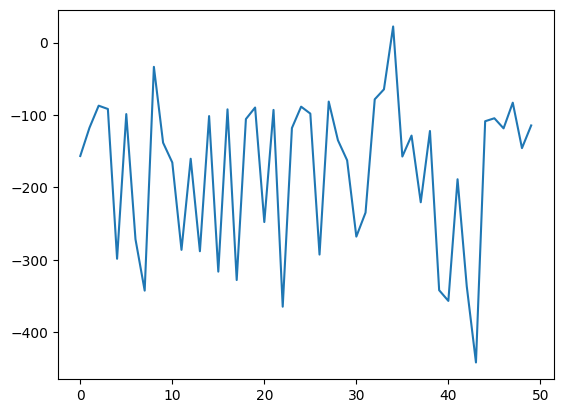


Recompensa de Media: -177.00273775093552 



In [30]:
# Evaluamos al Generador 
rewardMean=gan1.evaluate_G()
print('\nRecompensa de Media:', rewardMean, '\n')

## Experimento 2

In [31]:
expert_observations = np.genfromtxt("observations_LunarLander.csv",delimiter="\t",dtype=str)
expert_actions = np.genfromtxt('actions_LunarLander.csv', dtype=np.int32)
expert_num_tray=np.genfromtxt('n_trayectoria_LunarLander.csv', dtype=np.int32)

# Reemplazar las comas
expert_observations = np.core.defchararray.replace(expert_observations, ',', ' ')

# Crear un nuevo array para almacenar los datos convertidos
converted_observations = np.genfromtxt(expert_observations, delimiter=' ', dtype=float)

print("\n\tEstados reales: \n", converted_observations)
print("\tAcciones reales: \n", expert_actions)


	Estados reales: 
 [[-0.00655632  1.412633   -0.6640952  ...  0.15042743  0.
   0.        ]
 [-0.01301994  1.4137701  -0.65149987 ...  0.1017526   0.
   0.        ]
 [-0.01941118  1.414314   -0.6424104  ...  0.06514421  0.
   0.        ]
 ...
 [-0.46665245 -0.0082029   0.03071342 ...  0.67170596  1.
   1.        ]
 [-0.4661541  -0.01350838  0.02066027 ...  0.635882    1.
   1.        ]
 [-0.46567154 -0.01838761  0.02184356 ...  0.58443296  1.
   1.        ]]
	Acciones reales: 
 [3 3 3 ... 0 3 3]


In [32]:
longitud_trayectoria += np.count_nonzero(expert_num_tray == 1)
print(longitud_trayectoria)

1127


In [33]:
converted_observations=converted_observations[0:longitud_trayectoria]
expert_actions=expert_actions[0:longitud_trayectoria]

In [34]:
# Construimos el dataset [s,a] reales y lo dividimos en training y test
expert_a_one_hot=np.eye(env.action_space.n)[expert_actions]

dataset=np.concatenate([converted_observations,expert_a_one_hot],axis=1)


print(dataset)

# Divide los datos en conjuntos de entrenamiento y prueba
X_train, X_test = train_test_split(dataset, test_size=0.2, random_state=0)


#Imprime el número de elementos en el conjuntos de entrenamiento y prueba
print('Nº de (ESTADOS,ACCIONES) en el conjunto de entrenamiento:', len(X_train))
print('Nº de (ESTADOS,ACCIONES) en el conjunto de prueba:', len(X_test))

[[-6.5563200e-03  1.4126330e+00 -6.6409520e-01 ...  0.0000000e+00
   0.0000000e+00  1.0000000e+00]
 [-1.3019944e-02  1.4137701e+00 -6.5149987e-01 ...  0.0000000e+00
   0.0000000e+00  1.0000000e+00]
 [-1.9411182e-02  1.4143140e+00 -6.4241040e-01 ...  0.0000000e+00
   0.0000000e+00  1.0000000e+00]
 ...
 [ 5.7585880e-01 -1.8368971e-01 -2.2056554e-08 ...  0.0000000e+00
   0.0000000e+00  0.0000000e+00]
 [ 5.7585880e-01 -1.8368971e-01 -3.6117143e-08 ...  0.0000000e+00
   0.0000000e+00  0.0000000e+00]
 [ 5.7585880e-01 -1.8368971e-01 -4.6132280e-08 ...  0.0000000e+00
   0.0000000e+00  0.0000000e+00]]
Nº de (ESTADOS,ACCIONES) en el conjunto de entrenamiento: 901
Nº de (ESTADOS,ACCIONES) en el conjunto de prueba: 226


In [35]:
env= gym.make('LunarLander-v2')
obs,_= env.reset()

# Generador
generator=Policy_net( 'policy', env, obs)

# Generamos [s,a, s', r] falsas y las políticas theta_i y theta_i+1
observations, actions, rewards, Old_Policy, Policy=generator.generate_fakes()

# Discriminador
discriminator=Discriminator(env, discriminator_net, converted_observations, expert_actions, observations, actions)

### Definición de GAIL

In [36]:
gan2=GAN(discriminator=discriminator,generator=generator)

### Compilación de GAIL

In [37]:
tf.config.run_functions_eagerly(True)
gan2.compile(
    d_optimizer=tf.keras.optimizers.Adam(learning_rate=LEARNING_RATE),
    loss_fn_D=loss_fn_D
)

### Entrenamiento de GAIL

In [38]:
# Deshabilitar los mensajes de información de TensorFlow
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

# Deshabilitar los mensajes de información de OpenAI Gym
gym.logger.set_level(40)

BATCH_SIZE= round(len(X_train)/300)

history=gan2.fit(X_train,
    epochs=EPOCHS, batch_size=BATCH_SIZE)


301/301 [==============================] - 6115s 20s/step - d_loss: 1.9137 - g_loss: nan


### Evaluación de GAIL

In [39]:
# Evaluamos el Discriminador de GAIL en el TEST
gan2.evaluate_D(X_test)


1/1 [==============================] - 0s 19ms/step - loss: 3.6695e-06 - accuracy: 0.0000e+00
>Loss real: 
0.000227268785238266
>Loss fake: 
3.6695191738544963e-06


Episode  0 Total reward: -90.4928172955867
Episode  1 Total reward: -156.8840137558734
Episode  2 Total reward: -73.7366509357973
Episode  3 Total reward: -176.29552726865154
Episode  4 Total reward: -56.0865586225444
Episode  5 Total reward: -331.52305561229764
Episode  6 Total reward: -120.54384012338954
Episode  7 Total reward: -159.62398329735726
Episode  8 Total reward: -93.42018758085455
Episode  9 Total reward: -84.52673709815464
Episode  10 Total reward: -349.833300784835
Episode  11 Total reward: -316.73106885816514
Episode  12 Total reward: -199.8481554837615
Episode  13 Total reward: -127.42938761711301
Episode  14 Total reward: -127.30276801333395
Episode  15 Total reward: -83.73692304278921
Episode  16 Total reward: -223.53893654230848
Episode  17 Total reward: -53.85694050259967
Episode  18 Total reward: -34.020841384292225
Episode  19 Total reward: -189.04355002384744
Episode  20 Total reward: 18.76937413107275
Episode  21 Total reward: -84.22686369959361
Episode  22 Tot

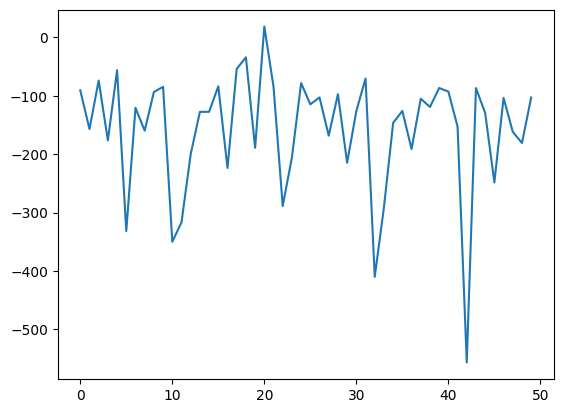


Recompensa de Media: -157.3880763415462 



In [40]:
# Evaluamos al Generador 
rewardMean=gan2.evaluate_G()
print('\nRecompensa de Media:', rewardMean, '\n')

## Experimento 3

In [41]:
expert_observations = np.genfromtxt("observations_LunarLander.csv",delimiter="\t",dtype=str)
expert_actions = np.genfromtxt('actions_LunarLander.csv', dtype=np.int32)
expert_num_tray=np.genfromtxt('n_trayectoria_LunarLander.csv', dtype=np.int32)

# Reemplazar las comas
expert_observations = np.core.defchararray.replace(expert_observations, ',', ' ')

# Crear un nuevo array para almacenar los datos convertidos
converted_observations = np.genfromtxt(expert_observations, delimiter=' ', dtype=float)

print("\n\tEstados reales: \n", converted_observations)
print("\tAcciones reales: \n", expert_actions)


	Estados reales: 
 [[-0.00655632  1.412633   -0.6640952  ...  0.15042743  0.
   0.        ]
 [-0.01301994  1.4137701  -0.65149987 ...  0.1017526   0.
   0.        ]
 [-0.01941118  1.414314   -0.6424104  ...  0.06514421  0.
   0.        ]
 ...
 [-0.46665245 -0.0082029   0.03071342 ...  0.67170596  1.
   1.        ]
 [-0.4661541  -0.01350838  0.02066027 ...  0.635882    1.
   1.        ]
 [-0.46567154 -0.01838761  0.02184356 ...  0.58443296  1.
   1.        ]]
	Acciones reales: 
 [3 3 3 ... 0 3 3]


In [42]:
longitud_trayectoria += np.count_nonzero(expert_num_tray == 2)
print(longitud_trayectoria)

1572


In [43]:
converted_observations=converted_observations[0:longitud_trayectoria]
expert_actions=expert_actions[0:longitud_trayectoria]

In [44]:
# Construimos el dataset [s,a] reales y lo dividimos en training y test
expert_a_one_hot=np.eye(env.action_space.n)[expert_actions]

dataset=np.concatenate([converted_observations,expert_a_one_hot],axis=1)


print(dataset)

# Divide los datos en conjuntos de entrenamiento y prueba
X_train, X_test = train_test_split(dataset, test_size=0.2, random_state=0)


#Imprime el número de elementos en el conjuntos de entrenamiento y prueba
print('Nº de (ESTADOS,ACCIONES) en el conjunto de entrenamiento:', len(X_train))
print('Nº de (ESTADOS,ACCIONES) en el conjunto de prueba:', len(X_test))

[[-0.00655632  1.412633   -0.6640952  ...  0.          0.
   1.        ]
 [-0.01301994  1.4137701  -0.65149987 ...  0.          0.
   1.        ]
 [-0.01941118  1.414314   -0.6424104  ...  0.          0.
   1.        ]
 ...
 [ 0.4179185   0.11636597 -0.10107721 ...  0.          1.
   0.        ]
 [ 0.41688195  0.11385406 -0.10168035 ...  0.          1.
   0.        ]
 [ 0.41580305  0.11141074 -0.10570452 ...  0.          1.
   0.        ]]
Nº de (ESTADOS,ACCIONES) en el conjunto de entrenamiento: 1257
Nº de (ESTADOS,ACCIONES) en el conjunto de prueba: 315


In [45]:
env= gym.make('LunarLander-v2')
obs,_= env.reset()

# Generador
generator=Policy_net( 'policy', env, obs)

# Generamos [s,a, s', r] falsas y las políticas theta_i y theta_i+1
observations, actions, rewards, Old_Policy, Policy=generator.generate_fakes()

# Discriminador
discriminator=Discriminator(env, discriminator_net, converted_observations, expert_actions, observations, actions)

### Definición de GAIL

In [46]:
gan3=GAN(discriminator=discriminator,generator=generator)

### Compilación de GAIL

In [47]:
tf.config.run_functions_eagerly(True)
gan3.compile(
    d_optimizer=tf.keras.optimizers.Adam(learning_rate=LEARNING_RATE),
    loss_fn_D=loss_fn_D
)

### Entrenamiento de GAIL

In [48]:
# Deshabilitar los mensajes de información de TensorFlow
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

# Deshabilitar los mensajes de información de OpenAI Gym
gym.logger.set_level(40)

BATCH_SIZE= round(len(X_train)/300)

history=gan3.fit(X_train,
    epochs=EPOCHS, batch_size=BATCH_SIZE)


315/315 [==============================] - 6562s 21s/step - d_loss: 1.9003 - g_loss: nan


### Evaluación de GAIL

In [49]:
# Evaluamos el Discriminador de GAIL en el TEST
gan3.evaluate_D(X_test)


1/1 [==============================] - 0s 21ms/step - loss: 0.0000e+00 - accuracy: 0.0000e+00
>Loss real: 
1.4125596408121055e-06
>Loss fake: 
0.0


Episode  0 Total reward: -95.45192845164
Episode  1 Total reward: -145.93790258787868
Episode  2 Total reward: -60.80868430550685
Episode  3 Total reward: -251.77638865872186
Episode  4 Total reward: -110.82244167818446
Episode  5 Total reward: -262.9780686514806
Episode  6 Total reward: -201.58462715467334
Episode  7 Total reward: -97.72928609777033
Episode  8 Total reward: -147.51413143159158
Episode  9 Total reward: -224.91932995994853
Episode  10 Total reward: -64.60352788340496
Episode  11 Total reward: -101.51033399970802
Episode  12 Total reward: -222.16733555852937
Episode  13 Total reward: -62.34339952033926
Episode  14 Total reward: -128.32142786330806
Episode  15 Total reward: -108.39329247725229
Episode  16 Total reward: -112.73165917044875
Episode  17 Total reward: -241.87598910606806
Episode  18 Total reward: -92.9405911495097
Episode  19 Total reward: -102.82207594998896
Episode  20 Total reward: -113.60390749590599
Episode  21 Total reward: -127.34902313153582
Episode  

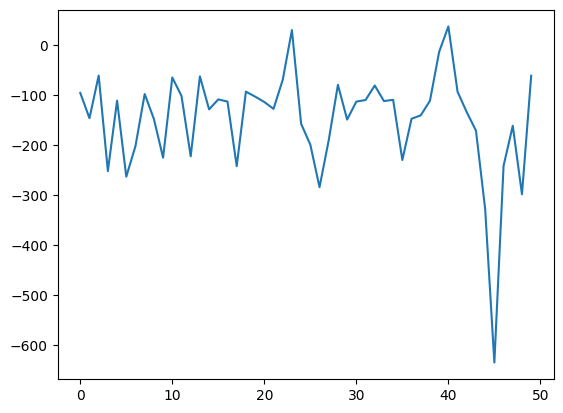


Recompensa de Media: -148.5001983038289 



In [50]:
# Evaluamos al Generador 
rewardMean=gan3.evaluate_G()
print('\nRecompensa de Media:', rewardMean, '\n')

## Experimento 4

In [51]:
expert_observations = np.genfromtxt("observations_LunarLander.csv",delimiter="\t",dtype=str)
expert_actions = np.genfromtxt('actions_LunarLander.csv', dtype=np.int32)
expert_num_tray=np.genfromtxt('n_trayectoria_LunarLander.csv', dtype=np.int32)

# Reemplazar las comas
expert_observations = np.core.defchararray.replace(expert_observations, ',', ' ')

# Crear un nuevo array para almacenar los datos convertidos
converted_observations = np.genfromtxt(expert_observations, delimiter=' ', dtype=float)

print("\n\tEstados reales: \n", converted_observations)
print("\tAcciones reales: \n", expert_actions)


	Estados reales: 
 [[-0.00655632  1.412633   -0.6640952  ...  0.15042743  0.
   0.        ]
 [-0.01301994  1.4137701  -0.65149987 ...  0.1017526   0.
   0.        ]
 [-0.01941118  1.414314   -0.6424104  ...  0.06514421  0.
   0.        ]
 ...
 [-0.46665245 -0.0082029   0.03071342 ...  0.67170596  1.
   1.        ]
 [-0.4661541  -0.01350838  0.02066027 ...  0.635882    1.
   1.        ]
 [-0.46567154 -0.01838761  0.02184356 ...  0.58443296  1.
   1.        ]]
	Acciones reales: 
 [3 3 3 ... 0 3 3]


In [52]:
longitud_trayectoria += np.count_nonzero(expert_num_tray == 3)
print(longitud_trayectoria)

2168


In [53]:
converted_observations=converted_observations[0:longitud_trayectoria]
expert_actions=expert_actions[0:longitud_trayectoria]

In [54]:
# Construimos el dataset [s,a] reales y lo dividimos en training y test
expert_a_one_hot=np.eye(env.action_space.n)[expert_actions]

dataset=np.concatenate([converted_observations,expert_a_one_hot],axis=1)


print(dataset)

# Divide los datos en conjuntos de entrenamiento y prueba
X_train, X_test = train_test_split(dataset, test_size=0.2, random_state=0)


#Imprime el número de elementos en el conjuntos de entrenamiento y prueba
print('Nº de (ESTADOS,ACCIONES) en el conjunto de entrenamiento:', len(X_train))
print('Nº de (ESTADOS,ACCIONES) en el conjunto de prueba:', len(X_test))

[[-6.5563200e-03  1.4126330e+00 -6.6409520e-01 ...  0.0000000e+00
   0.0000000e+00  1.0000000e+00]
 [-1.3019944e-02  1.4137701e+00 -6.5149987e-01 ...  0.0000000e+00
   0.0000000e+00  1.0000000e+00]
 [-1.9411182e-02  1.4143140e+00 -6.4241040e-01 ...  0.0000000e+00
   0.0000000e+00  1.0000000e+00]
 ...
 [ 4.1053313e-01  4.4803914e-02  2.5128000e-04 ...  0.0000000e+00
   0.0000000e+00  1.0000000e+00]
 [ 4.1053715e-01  4.4805490e-02  4.1009445e-04 ...  0.0000000e+00
   0.0000000e+00  1.0000000e+00]
 [ 4.1053790e-01  4.4805700e-02  7.5154120e-05 ...  0.0000000e+00
   0.0000000e+00  1.0000000e+00]]
Nº de (ESTADOS,ACCIONES) en el conjunto de entrenamiento: 1734
Nº de (ESTADOS,ACCIONES) en el conjunto de prueba: 434


In [55]:
env= gym.make('LunarLander-v2')
obs,_= env.reset()

# Generador
generator=Policy_net( 'policy', env, obs)

# Generamos [s,a, s', r] falsas y las políticas theta_i y theta_i+1
observations, actions, rewards, Old_Policy, Policy=generator.generate_fakes()

# Discriminador
discriminator=Discriminator(env, discriminator_net, converted_observations, expert_actions, observations, actions)

### Definición de GAIL

In [56]:
gan4=GAN(discriminator=discriminator,generator=generator)

### Compilación de GAIL

In [57]:
tf.config.run_functions_eagerly(True)
gan4.compile(
    d_optimizer=tf.keras.optimizers.Adam(learning_rate=LEARNING_RATE),
    loss_fn_D=loss_fn_D
)

### Entrenamiento de GAIL

In [58]:
# Deshabilitar los mensajes de información de TensorFlow
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

# Deshabilitar los mensajes de información de OpenAI Gym
gym.logger.set_level(40)

BATCH_SIZE= round(len(X_train)/300)

history=gan4.fit(X_train,
    epochs=EPOCHS, batch_size=BATCH_SIZE)


289/289 [==============================] - 5904s 20s/step - d_loss: 1.9049 - g_loss: nan


### Evaluación de GAIL

In [59]:
# Evaluamos el Discriminador de GAIL en el TEST
gan4.evaluate_D(X_test)


1/1 [==============================] - 0s 19ms/step - loss: 0.0000e+00 - accuracy: 0.0000e+00
>Loss real: 
1.7991267142747347e-08
>Loss fake: 
0.0


Episode  0 Total reward: -119.66007465686565
Episode  1 Total reward: -227.6559369393354
Episode  2 Total reward: -435.5886582474683
Episode  3 Total reward: -126.8672130855341
Episode  4 Total reward: -198.97589489200217
Episode  5 Total reward: -138.15735378673827
Episode  6 Total reward: -227.07293832433533
Episode  7 Total reward: -189.1103186364707
Episode  8 Total reward: -119.24439191014424
Episode  9 Total reward: 13.85030102938012
Episode  10 Total reward: -80.70313429331335
Episode  11 Total reward: -344.105469678998
Episode  12 Total reward: -226.38942061264854
Episode  13 Total reward: -124.27833700765109
Episode  14 Total reward: -117.1863220210063
Episode  15 Total reward: -74.33949248726701
Episode  16 Total reward: -243.02455139378426
Episode  17 Total reward: -84.90091867453803
Episode  18 Total reward: -128.89606020939752
Episode  19 Total reward: -134.0729822634067
Episode  20 Total reward: -155.28743764608078
Episode  21 Total reward: -219.28309977846936
Episode  22

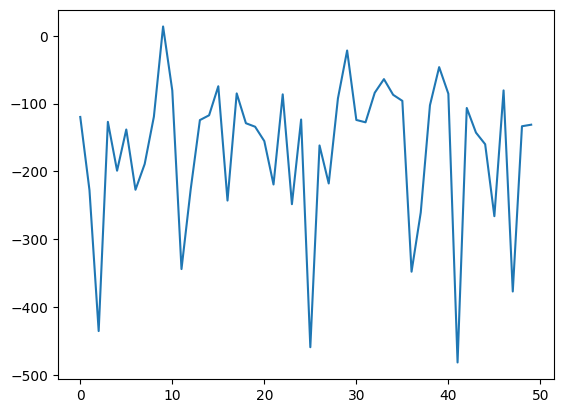


Recompensa de Media: -168.3219037366577 



In [60]:
# Evaluamos al Generador 
rewardMean=gan4.evaluate_G()
print('\nRecompensa de Media:', rewardMean, '\n')

## Experimento 5

In [61]:
expert_observations = np.genfromtxt("observations_LunarLander.csv",delimiter="\t",dtype=str)
expert_actions = np.genfromtxt('actions_LunarLander.csv', dtype=np.int32)
expert_num_tray=np.genfromtxt('n_trayectoria_LunarLander.csv', dtype=np.int32)

# Reemplazar las comas
expert_observations = np.core.defchararray.replace(expert_observations, ',', ' ')

# Crear un nuevo array para almacenar los datos convertidos
converted_observations = np.genfromtxt(expert_observations, delimiter=' ', dtype=float)

print("\n\tEstados reales: \n", converted_observations)
print("\tAcciones reales: \n", expert_actions)


	Estados reales: 
 [[-0.00655632  1.412633   -0.6640952  ...  0.15042743  0.
   0.        ]
 [-0.01301994  1.4137701  -0.65149987 ...  0.1017526   0.
   0.        ]
 [-0.01941118  1.414314   -0.6424104  ...  0.06514421  0.
   0.        ]
 ...
 [-0.46665245 -0.0082029   0.03071342 ...  0.67170596  1.
   1.        ]
 [-0.4661541  -0.01350838  0.02066027 ...  0.635882    1.
   1.        ]
 [-0.46567154 -0.01838761  0.02184356 ...  0.58443296  1.
   1.        ]]
	Acciones reales: 
 [3 3 3 ... 0 3 3]


In [62]:
longitud_trayectoria += np.count_nonzero(expert_num_tray == 4)
print(longitud_trayectoria)

3158


In [63]:
converted_observations=converted_observations[0:longitud_trayectoria]
expert_actions=expert_actions[0:longitud_trayectoria]

In [64]:
# Construimos el dataset [s,a] reales y lo dividimos en training y test
expert_a_one_hot=np.eye(env.action_space.n)[expert_actions]

dataset=np.concatenate([converted_observations,expert_a_one_hot],axis=1)


print(dataset)

# Divide los datos en conjuntos de entrenamiento y prueba
X_train, X_test = train_test_split(dataset, test_size=0.2, random_state=0)


#Imprime el número de elementos en el conjuntos de entrenamiento y prueba
print('Nº de (ESTADOS,ACCIONES) en el conjunto de entrenamiento:', len(X_train))
print('Nº de (ESTADOS,ACCIONES) en el conjunto de prueba:', len(X_test))

[[-6.5563200e-03  1.4126330e+00 -6.6409520e-01 ...  0.0000000e+00
   0.0000000e+00  1.0000000e+00]
 [-1.3019944e-02  1.4137701e+00 -6.5149987e-01 ...  0.0000000e+00
   0.0000000e+00  1.0000000e+00]
 [-1.9411182e-02  1.4143140e+00 -6.4241040e-01 ...  0.0000000e+00
   0.0000000e+00  1.0000000e+00]
 ...
 [ 6.7724630e-01  4.2385206e-02  5.4524446e-07 ...  0.0000000e+00
   0.0000000e+00  0.0000000e+00]
 [ 6.7724630e-01  4.2385206e-02  1.1408074e-07 ...  0.0000000e+00
   0.0000000e+00  0.0000000e+00]
 [ 6.7724630e-01  4.2385206e-02 -2.4774107e-07 ...  0.0000000e+00
   0.0000000e+00  0.0000000e+00]]
Nº de (ESTADOS,ACCIONES) en el conjunto de entrenamiento: 2526
Nº de (ESTADOS,ACCIONES) en el conjunto de prueba: 632


In [65]:
env= gym.make('LunarLander-v2')
obs,_= env.reset()

# Generador
generator=Policy_net( 'policy', env, obs)

# Generamos [s,a, s', r] falsas y las políticas theta_i y theta_i+1
observations, actions, rewards, Old_Policy, Policy=generator.generate_fakes()

# Discriminador
discriminator=Discriminator(env, discriminator_net, converted_observations, expert_actions, observations, actions)

### Definición de GAIL

In [66]:
gan5=GAN(discriminator=discriminator,generator=generator)

### Compilación de GAIL

In [67]:
tf.config.run_functions_eagerly(True)
gan5.compile(
    d_optimizer=tf.keras.optimizers.Adam(learning_rate=LEARNING_RATE),
    loss_fn_D=loss_fn_D
)

### Entrenamiento de GAIL

In [68]:
# Deshabilitar los mensajes de información de TensorFlow
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

# Deshabilitar los mensajes de información de OpenAI Gym
gym.logger.set_level(40)

BATCH_SIZE= round(len(X_train)/300)

history=gan5.fit(X_train,
    epochs=EPOCHS, batch_size=BATCH_SIZE)


316/316 [==============================] - 6457s 20s/step - d_loss: 1.8919 - g_loss: nan


### Evaluación de GAIL

In [69]:
# Evaluamos el Discriminador de GAIL en el TEST
gan5.evaluate_D(X_test)


1/1 [==============================] - 0s 19ms/step - loss: 0.0000e+00 - accuracy: 0.0000e+00
>Loss real: 
2.4520900865354633e-09
>Loss fake: 
0.0


Episode  0 Total reward: -337.73982868013866
Episode  1 Total reward: -97.35030291786583
Episode  2 Total reward: -108.9411874271131
Episode  3 Total reward: -162.0398383945269
Episode  4 Total reward: -131.29285141485244
Episode  5 Total reward: -94.67768264977636
Episode  6 Total reward: -164.12434076447826
Episode  7 Total reward: -38.057436058637464
Episode  8 Total reward: -245.82415360084306
Episode  9 Total reward: -141.3362801333539
Episode  10 Total reward: -78.34544875440693
Episode  11 Total reward: -24.964117664773553
Episode  12 Total reward: -75.3498813741256
Episode  13 Total reward: -82.16800235889295
Episode  14 Total reward: -237.02242565012236
Episode  15 Total reward: -79.88722499786658
Episode  16 Total reward: -105.85222932813457
Episode  17 Total reward: -149.8695589824937
Episode  18 Total reward: -108.05092488071494
Episode  19 Total reward: -341.6061589104618
Episode  20 Total reward: -67.54386203414298
Episode  21 Total reward: -123.30294864819697
Episode  22

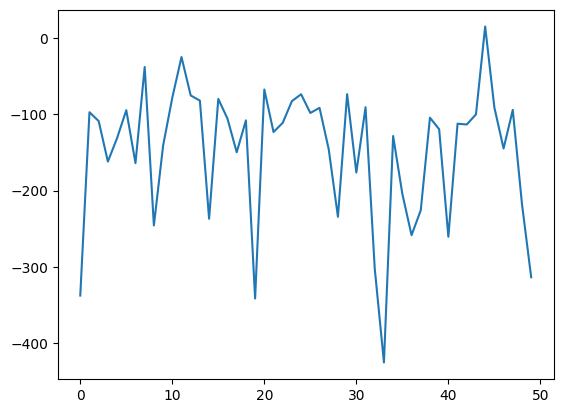


Recompensa de Media: -147.54106390009576 



In [70]:
# Evaluamos al Generador 
rewardMean=gan5.evaluate_G()
print('\nRecompensa de Media:', rewardMean, '\n')

## Experimento 6

In [71]:
expert_observations = np.genfromtxt("observations_LunarLander.csv",delimiter="\t",dtype=str)
expert_actions = np.genfromtxt('actions_LunarLander.csv', dtype=np.int32)
expert_num_tray=np.genfromtxt('n_trayectoria_LunarLander.csv', dtype=np.int32)

# Reemplazar las comas
expert_observations = np.core.defchararray.replace(expert_observations, ',', ' ')

# Crear un nuevo array para almacenar los datos convertidos
converted_observations = np.genfromtxt(expert_observations, delimiter=' ', dtype=float)

print("\n\tEstados reales: \n", converted_observations)
print("\tAcciones reales: \n", expert_actions)


	Estados reales: 
 [[-0.00655632  1.412633   -0.6640952  ...  0.15042743  0.
   0.        ]
 [-0.01301994  1.4137701  -0.65149987 ...  0.1017526   0.
   0.        ]
 [-0.01941118  1.414314   -0.6424104  ...  0.06514421  0.
   0.        ]
 ...
 [-0.46665245 -0.0082029   0.03071342 ...  0.67170596  1.
   1.        ]
 [-0.4661541  -0.01350838  0.02066027 ...  0.635882    1.
   1.        ]
 [-0.46567154 -0.01838761  0.02184356 ...  0.58443296  1.
   1.        ]]
	Acciones reales: 
 [3 3 3 ... 0 3 3]


In [72]:
longitud_trayectoria += np.count_nonzero(expert_num_tray == 5)
print(longitud_trayectoria)

4158


In [73]:
converted_observations=converted_observations[0:longitud_trayectoria]
expert_actions=expert_actions[0:longitud_trayectoria]

In [74]:
# Construimos el dataset [s,a] reales y lo dividimos en training y test
expert_a_one_hot=np.eye(env.action_space.n)[expert_actions]

dataset=np.concatenate([converted_observations,expert_a_one_hot],axis=1)


print(dataset)

# Divide los datos en conjuntos de entrenamiento y prueba
X_train, X_test = train_test_split(dataset, test_size=0.2, random_state=0)


#Imprime el número de elementos en el conjuntos de entrenamiento y prueba
print('Nº de (ESTADOS,ACCIONES) en el conjunto de entrenamiento:', len(X_train))
print('Nº de (ESTADOS,ACCIONES) en el conjunto de prueba:', len(X_test))

[[-6.5563200e-03  1.4126330e+00 -6.6409520e-01 ...  0.0000000e+00
   0.0000000e+00  1.0000000e+00]
 [-1.3019944e-02  1.4137701e+00 -6.5149987e-01 ...  0.0000000e+00
   0.0000000e+00  1.0000000e+00]
 [-1.9411182e-02  1.4143140e+00 -6.4241040e-01 ...  0.0000000e+00
   0.0000000e+00  1.0000000e+00]
 ...
 [ 3.2675964e-01 -5.1517500e-02 -1.6227339e-03 ...  0.0000000e+00
   0.0000000e+00  0.0000000e+00]
 [ 3.2676880e-01 -5.1521648e-02  9.4594294e-04 ...  0.0000000e+00
   0.0000000e+00  0.0000000e+00]
 [ 3.2677516e-01 -5.1524438e-02  6.5785140e-04 ...  0.0000000e+00
   0.0000000e+00  0.0000000e+00]]
Nº de (ESTADOS,ACCIONES) en el conjunto de entrenamiento: 3326
Nº de (ESTADOS,ACCIONES) en el conjunto de prueba: 832


In [75]:
env= gym.make('LunarLander-v2')
obs,_= env.reset()

# Generador
generator=Policy_net( 'policy', env, obs)

# Generamos [s,a, s', r] falsas y las políticas theta_i y theta_i+1
observations, actions, rewards, Old_Policy, Policy=generator.generate_fakes()

# Discriminador
discriminator=Discriminator(env, discriminator_net, converted_observations, expert_actions, observations, actions)

### Definición de GAIL

In [76]:
gan6=GAN(discriminator=discriminator,generator=generator)

### Compilación de GAIL

In [77]:
tf.config.run_functions_eagerly(True)
gan6.compile(
    d_optimizer=tf.keras.optimizers.Adam(learning_rate=LEARNING_RATE),
    loss_fn_D=loss_fn_D
)

### Entrenamiento de GAIL

In [78]:
# Deshabilitar los mensajes de información de TensorFlow
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

# Deshabilitar los mensajes de información de OpenAI Gym
gym.logger.set_level(40)

BATCH_SIZE= round(len(X_train)/300)

history=gan6.fit(X_train,
    epochs=EPOCHS, batch_size=BATCH_SIZE)


303/303 [==============================] - 6192s 20s/step - d_loss: 1.9045 - g_loss: nan


### Evaluación de GAIL

In [79]:
# Evaluamos el Discriminador de GAIL en el TEST
gan6.evaluate_D(X_test)


1/1 [==============================] - 0s 19ms/step - loss: 0.0000e+00 - accuracy: 0.0000e+00
>Loss real: 
2.364127116294412e-09
>Loss fake: 
0.0


Episode  0 Total reward: -129.98789758979686
Episode  1 Total reward: -35.39668320861753
Episode  2 Total reward: -340.4187399797877
Episode  3 Total reward: -90.42177019225512
Episode  4 Total reward: -22.368833799674007
Episode  5 Total reward: -53.71865890603536
Episode  6 Total reward: -29.138763687705918
Episode  7 Total reward: -74.11036880913029
Episode  8 Total reward: -38.860461296910074
Episode  9 Total reward: -160.8941267266215
Episode  10 Total reward: -102.79160935446404
Episode  11 Total reward: -97.1752650392996
Episode  12 Total reward: -128.86221889682727
Episode  13 Total reward: -185.63515318122757
Episode  14 Total reward: -205.43584981730248
Episode  15 Total reward: -183.0231170215757
Episode  16 Total reward: -354.0723467389432
Episode  17 Total reward: -124.7170420282053
Episode  18 Total reward: -119.01908133805725
Episode  19 Total reward: -390.10971371352974
Episode  20 Total reward: -98.75625287480005
Episode  21 Total reward: -113.65945567086497
Episode  2

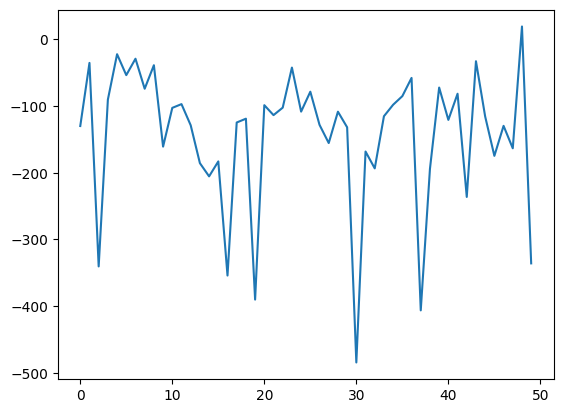


Recompensa de Media: -143.63319626366584 



In [80]:
# Evaluamos al Generador 
rewardMean=gan6.evaluate_G()
print('\nRecompensa de Media:', rewardMean, '\n')

## Experimento 7

In [81]:
expert_observations = np.genfromtxt("observations_LunarLander.csv",delimiter="\t",dtype=str)
expert_actions = np.genfromtxt('actions_LunarLander.csv', dtype=np.int32)
expert_num_tray=np.genfromtxt('n_trayectoria_LunarLander.csv', dtype=np.int32)

# Reemplazar las comas
expert_observations = np.core.defchararray.replace(expert_observations, ',', ' ')

# Crear un nuevo array para almacenar los datos convertidos
converted_observations = np.genfromtxt(expert_observations, delimiter=' ', dtype=float)

print("\n\tEstados reales: \n", converted_observations)
print("\tAcciones reales: \n", expert_actions)


	Estados reales: 
 [[-0.00655632  1.412633   -0.6640952  ...  0.15042743  0.
   0.        ]
 [-0.01301994  1.4137701  -0.65149987 ...  0.1017526   0.
   0.        ]
 [-0.01941118  1.414314   -0.6424104  ...  0.06514421  0.
   0.        ]
 ...
 [-0.46665245 -0.0082029   0.03071342 ...  0.67170596  1.
   1.        ]
 [-0.4661541  -0.01350838  0.02066027 ...  0.635882    1.
   1.        ]
 [-0.46567154 -0.01838761  0.02184356 ...  0.58443296  1.
   1.        ]]
	Acciones reales: 
 [3 3 3 ... 0 3 3]


In [82]:
longitud_trayectoria += np.count_nonzero(expert_num_tray == 6)
print(longitud_trayectoria)

4680


In [83]:
converted_observations=converted_observations[0:longitud_trayectoria]
expert_actions=expert_actions[0:longitud_trayectoria]

In [84]:
# Construimos el dataset [s,a] reales y lo dividimos en training y test
expert_a_one_hot=np.eye(env.action_space.n)[expert_actions]

dataset=np.concatenate([converted_observations,expert_a_one_hot],axis=1)


print(dataset)

# Divide los datos en conjuntos de entrenamiento y prueba
X_train, X_test = train_test_split(dataset, test_size=0.2, random_state=0)


#Imprime el número de elementos en el conjuntos de entrenamiento y prueba
print('Nº de (ESTADOS,ACCIONES) en el conjunto de entrenamiento:', len(X_train))
print('Nº de (ESTADOS,ACCIONES) en el conjunto de prueba:', len(X_test))

[[-6.5563200e-03  1.4126330e+00 -6.6409520e-01 ...  0.0000000e+00
   0.0000000e+00  1.0000000e+00]
 [-1.3019944e-02  1.4137701e+00 -6.5149987e-01 ...  0.0000000e+00
   0.0000000e+00  1.0000000e+00]
 [-1.9411182e-02  1.4143140e+00 -6.4241040e-01 ...  0.0000000e+00
   0.0000000e+00  1.0000000e+00]
 ...
 [-8.6160660e-03 -1.2264752e-03  5.3442470e-08 ...  0.0000000e+00
   0.0000000e+00  0.0000000e+00]
 [-8.6160660e-03 -1.2264752e-03  4.7162676e-08 ...  0.0000000e+00
   0.0000000e+00  0.0000000e+00]
 [-8.6160660e-03 -1.2264752e-03  3.9814470e-08 ...  0.0000000e+00
   0.0000000e+00  0.0000000e+00]]
Nº de (ESTADOS,ACCIONES) en el conjunto de entrenamiento: 3744
Nº de (ESTADOS,ACCIONES) en el conjunto de prueba: 936


In [85]:
env= gym.make('LunarLander-v2')
obs,_= env.reset()

# Generador
generator=Policy_net( 'policy', env, obs)

# Generamos [s,a, s', r] falsas y las políticas theta_i y theta_i+1
observations, actions, rewards, Old_Policy, Policy=generator.generate_fakes()

# Discriminador
discriminator=Discriminator(env, discriminator_net, converted_observations, expert_actions, observations, actions)

### Definición de GAIL

In [86]:
gan7=GAN(discriminator=discriminator,generator=generator)

### Compilación de GAIL

In [87]:
tf.config.run_functions_eagerly(True)
gan7.compile(
    d_optimizer=tf.keras.optimizers.Adam(learning_rate=LEARNING_RATE),
    loss_fn_D=loss_fn_D
)

### Entrenamiento de GAIL

In [88]:
# Deshabilitar los mensajes de información de TensorFlow
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

# Deshabilitar los mensajes de información de OpenAI Gym
gym.logger.set_level(40)

BATCH_SIZE= round(len(X_train)/300)

history=gan7.fit(X_train,
    epochs=EPOCHS, batch_size=BATCH_SIZE)


312/312 [==============================] - 6450s 21s/step - d_loss: 1.8962 - g_loss: nan


### Evaluación de GAIL

In [89]:
# Evaluamos el Discriminador de GAIL en el TEST
gan7.evaluate_D(X_test)


1/1 [==============================] - 0s 21ms/step - loss: 0.0000e+00 - accuracy: 0.0000e+00
>Loss real: 
1.0825631502342503e-09
>Loss fake: 
0.0


Episode  0 Total reward: -97.13622653439194
Episode  1 Total reward: -147.45417357624405
Episode  2 Total reward: -169.69343504264634
Episode  3 Total reward: -88.28256925717413
Episode  4 Total reward: -139.63369456898528
Episode  5 Total reward: -161.43192021572736
Episode  6 Total reward: -203.5252236952404
Episode  7 Total reward: -107.35997077717602
Episode  8 Total reward: -325.32612950379485
Episode  9 Total reward: -206.39591622331793
Episode  10 Total reward: -341.9954984554796
Episode  11 Total reward: -133.0329007201417
Episode  12 Total reward: -248.71651534554434
Episode  13 Total reward: -122.20223110959557
Episode  14 Total reward: -169.49100630238974
Episode  15 Total reward: -136.44944190861355
Episode  16 Total reward: -104.73388008788439
Episode  17 Total reward: -367.9122580348794
Episode  18 Total reward: -58.1137624206422
Episode  19 Total reward: -104.07460894715307
Episode  20 Total reward: -102.04457076640506
Episode  21 Total reward: -127.54327805116813
Episod

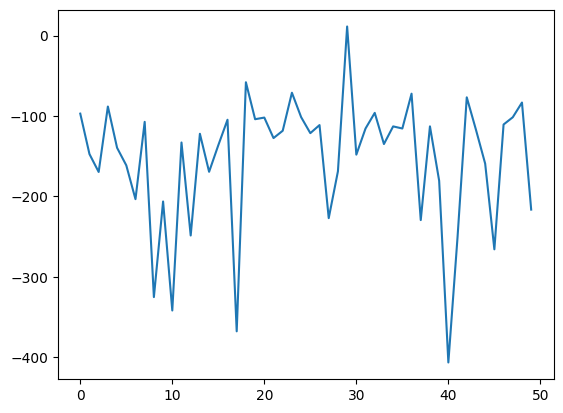


Recompensa de Media: -153.57296897714212 



In [90]:
# Evaluamos al Generador 
rewardMean=gan7.evaluate_G()
print('\nRecompensa de Media:', rewardMean, '\n')

## Experimento 8

In [91]:
expert_observations = np.genfromtxt("observations_LunarLander.csv",delimiter="\t",dtype=str)
expert_actions = np.genfromtxt('actions_LunarLander.csv', dtype=np.int32)
expert_num_tray=np.genfromtxt('n_trayectoria_LunarLander.csv', dtype=np.int32)

# Reemplazar las comas
expert_observations = np.core.defchararray.replace(expert_observations, ',', ' ')

# Crear un nuevo array para almacenar los datos convertidos
converted_observations = np.genfromtxt(expert_observations, delimiter=' ', dtype=float)

print("\n\tEstados reales: \n", converted_observations)
print("\tAcciones reales: \n", expert_actions)


	Estados reales: 
 [[-0.00655632  1.412633   -0.6640952  ...  0.15042743  0.
   0.        ]
 [-0.01301994  1.4137701  -0.65149987 ...  0.1017526   0.
   0.        ]
 [-0.01941118  1.414314   -0.6424104  ...  0.06514421  0.
   0.        ]
 ...
 [-0.46665245 -0.0082029   0.03071342 ...  0.67170596  1.
   1.        ]
 [-0.4661541  -0.01350838  0.02066027 ...  0.635882    1.
   1.        ]
 [-0.46567154 -0.01838761  0.02184356 ...  0.58443296  1.
   1.        ]]
	Acciones reales: 
 [3 3 3 ... 0 3 3]


In [92]:
longitud_trayectoria += np.count_nonzero(expert_num_tray == 7)
print(longitud_trayectoria)

5314


In [93]:
converted_observations=converted_observations[0:longitud_trayectoria]
expert_actions=expert_actions[0:longitud_trayectoria]

In [94]:
# Construimos el dataset [s,a] reales y lo dividimos en training y test
expert_a_one_hot=np.eye(env.action_space.n)[expert_actions]

dataset=np.concatenate([converted_observations,expert_a_one_hot],axis=1)


print(dataset)

# Divide los datos en conjuntos de entrenamiento y prueba
X_train, X_test = train_test_split(dataset, test_size=0.2, random_state=0)


#Imprime el número de elementos en el conjuntos de entrenamiento y prueba
print('Nº de (ESTADOS,ACCIONES) en el conjunto de entrenamiento:', len(X_train))
print('Nº de (ESTADOS,ACCIONES) en el conjunto de prueba:', len(X_test))

[[-6.5563200e-03  1.4126330e+00 -6.6409520e-01 ...  0.0000000e+00
   0.0000000e+00  1.0000000e+00]
 [-1.3019944e-02  1.4137701e+00 -6.5149987e-01 ...  0.0000000e+00
   0.0000000e+00  1.0000000e+00]
 [-1.9411182e-02  1.4143140e+00 -6.4241040e-01 ...  0.0000000e+00
   0.0000000e+00  1.0000000e+00]
 ...
 [ 1.3379402e-01  3.4672476e-03  6.3765560e-08 ...  0.0000000e+00
   0.0000000e+00  0.0000000e+00]
 [ 1.3379402e-01  3.4672476e-03  5.2665534e-08 ...  0.0000000e+00
   0.0000000e+00  0.0000000e+00]
 [ 1.3379402e-01  3.4672476e-03  4.0811244e-08 ...  0.0000000e+00
   0.0000000e+00  0.0000000e+00]]
Nº de (ESTADOS,ACCIONES) en el conjunto de entrenamiento: 4251
Nº de (ESTADOS,ACCIONES) en el conjunto de prueba: 1063


In [95]:
env= gym.make('LunarLander-v2')
obs,_= env.reset()

# Generador
generator=Policy_net( 'policy', env, obs)

# Generamos [s,a, s', r] falsas y las políticas theta_i y theta_i+1
observations, actions, rewards, Old_Policy, Policy=generator.generate_fakes()

# Discriminador
discriminator=Discriminator(env, discriminator_net, converted_observations, expert_actions, observations, actions)

### Definición de GAIL

In [96]:
gan8=GAN(discriminator=discriminator,generator=generator)

### Compilación de GAIL

In [97]:
tf.config.run_functions_eagerly(True)
gan8.compile(
    d_optimizer=tf.keras.optimizers.Adam(learning_rate=LEARNING_RATE),
    loss_fn_D=loss_fn_D
)

### Entrenamiento de GAIL

In [98]:
# Deshabilitar los mensajes de información de TensorFlow
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

# Deshabilitar los mensajes de información de OpenAI Gym
gym.logger.set_level(40)

BATCH_SIZE= round(len(X_train)/300)

history=gan8.fit(X_train,
    epochs=EPOCHS, batch_size=BATCH_SIZE)


304/304 [==============================] - 7360s 24s/step - d_loss: 1.8973 - g_loss: 1.4272


### Evaluación de GAIL

In [99]:
# Evaluamos el Discriminador de GAIL en el TEST
gan8.evaluate_D(X_test)


1/1 [==============================] - 0s 22ms/step - loss: 0.0000e+00 - accuracy: 0.0000e+00
>Loss real: 
1.121442175233689e-10
>Loss fake: 
0.0


Episode  0 Total reward: -126.72211358349519
Episode  1 Total reward: -94.40390212306504
Episode  2 Total reward: -118.56136959113806
Episode  3 Total reward: -68.03448024132243
Episode  4 Total reward: -97.96495043535676
Episode  5 Total reward: -46.421338599943994
Episode  6 Total reward: -67.26393649598427
Episode  7 Total reward: 0.028483480717895304
Episode  8 Total reward: -292.00199099033796
Episode  9 Total reward: -67.19226784005703
Episode  10 Total reward: -88.71799491814807
Episode  11 Total reward: -81.53361689557512
Episode  12 Total reward: -114.22311854872214
Episode  13 Total reward: -104.46102481046893
Episode  14 Total reward: -126.45559367796486
Episode  15 Total reward: -125.43441069233474
Episode  16 Total reward: -151.77999252365905
Episode  17 Total reward: -223.74833533196102
Episode  18 Total reward: -80.00125907782555
Episode  19 Total reward: -141.2374969193001
Episode  20 Total reward: -104.46286058695404
Episode  21 Total reward: -365.30483129044813
Episod

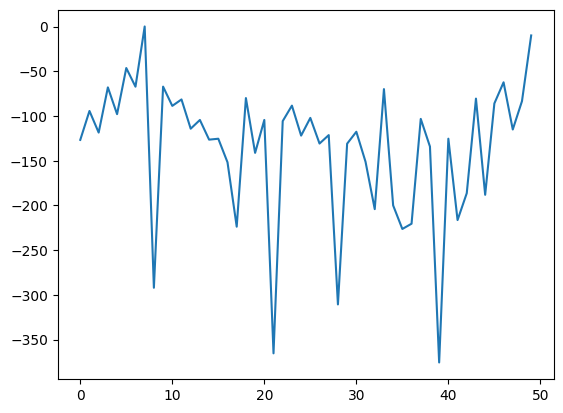


Recompensa de Media: -135.08281906769957 



In [100]:
# Evaluamos al Generador 
rewardMean=gan8.evaluate_G()
print('\nRecompensa de Media:', rewardMean, '\n')

## Experimento 9

In [101]:
expert_observations = np.genfromtxt("observations_LunarLander.csv",delimiter="\t",dtype=str)
expert_actions = np.genfromtxt('actions_LunarLander.csv', dtype=np.int32)
expert_num_tray=np.genfromtxt('n_trayectoria_LunarLander.csv', dtype=np.int32)

# Reemplazar las comas
expert_observations = np.core.defchararray.replace(expert_observations, ',', ' ')

# Crear un nuevo array para almacenar los datos convertidos
converted_observations = np.genfromtxt(expert_observations, delimiter=' ', dtype=float)

print("\n\tEstados reales: \n", converted_observations)
print("\tAcciones reales: \n", expert_actions)


	Estados reales: 
 [[-0.00655632  1.412633   -0.6640952  ...  0.15042743  0.
   0.        ]
 [-0.01301994  1.4137701  -0.65149987 ...  0.1017526   0.
   0.        ]
 [-0.01941118  1.414314   -0.6424104  ...  0.06514421  0.
   0.        ]
 ...
 [-0.46665245 -0.0082029   0.03071342 ...  0.67170596  1.
   1.        ]
 [-0.4661541  -0.01350838  0.02066027 ...  0.635882    1.
   1.        ]
 [-0.46567154 -0.01838761  0.02184356 ...  0.58443296  1.
   1.        ]]
	Acciones reales: 
 [3 3 3 ... 0 3 3]


In [102]:
longitud_trayectoria += np.count_nonzero(expert_num_tray == 8)
print(longitud_trayectoria)

5799


In [103]:
converted_observations=converted_observations[0:longitud_trayectoria]
expert_actions=expert_actions[0:longitud_trayectoria]

In [104]:
# Construimos el dataset [s,a] reales y lo dividimos en training y test
expert_a_one_hot=np.eye(env.action_space.n)[expert_actions]

dataset=np.concatenate([converted_observations,expert_a_one_hot],axis=1)


print(dataset)

# Divide los datos en conjuntos de entrenamiento y prueba
X_train, X_test = train_test_split(dataset, test_size=0.2, random_state=0)


#Imprime el número de elementos en el conjuntos de entrenamiento y prueba
print('Nº de (ESTADOS,ACCIONES) en el conjunto de entrenamiento:', len(X_train))
print('Nº de (ESTADOS,ACCIONES) en el conjunto de prueba:', len(X_test))

[[-0.00655632  1.412633   -0.6640952  ...  0.          0.
   1.        ]
 [-0.01301994  1.4137701  -0.65149987 ...  0.          0.
   1.        ]
 [-0.01941118  1.414314   -0.6424104  ...  0.          0.
   1.        ]
 ...
 [ 0.7474047   0.0260748  -0.02635835 ...  0.          0.
   0.        ]
 [ 0.74719274  0.02124918 -0.04889769 ...  0.          0.
   1.        ]
 [ 0.74685365  0.01683348 -0.05817185 ...  0.          0.
   1.        ]]
Nº de (ESTADOS,ACCIONES) en el conjunto de entrenamiento: 4639
Nº de (ESTADOS,ACCIONES) en el conjunto de prueba: 1160


In [105]:
env= gym.make('LunarLander-v2')
obs,_= env.reset()

# Generador
generator=Policy_net( 'policy', env, obs)

# Generamos [s,a, s', r] falsas y las políticas theta_i y theta_i+1
observations, actions, rewards, Old_Policy, Policy=generator.generate_fakes()

# Discriminador
discriminator=Discriminator(env, discriminator_net, converted_observations, expert_actions, observations, actions)

### Definición de GAIL

In [106]:
gan9=GAN(discriminator=discriminator,generator=generator)

### Compilación de GAIL

In [107]:
tf.config.run_functions_eagerly(True)
gan9.compile(
    d_optimizer=tf.keras.optimizers.Adam(learning_rate=LEARNING_RATE),
    loss_fn_D=loss_fn_D
)

### Entrenamiento de GAIL

In [108]:
# Deshabilitar los mensajes de información de TensorFlow
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

# Deshabilitar los mensajes de información de OpenAI Gym
gym.logger.set_level(40)

BATCH_SIZE= round(len(X_train)/300)

history=gan9.fit(X_train,
    epochs=EPOCHS, batch_size=BATCH_SIZE)


310/310 [==============================] - 6569s 21s/step - d_loss: 1.8976 - g_loss: nan


### Evaluación de GAIL

In [109]:
# Evaluamos el Discriminador de GAIL en el TEST
gan9.evaluate_D(X_test)


1/1 [==============================] - 0s 22ms/step - loss: 0.0000e+00 - accuracy: 0.0000e+00
>Loss real: 
2.0553328483607913e-10
>Loss fake: 
0.0


Episode  0 Total reward: -178.64072497588575
Episode  1 Total reward: -378.6101542957175
Episode  2 Total reward: -123.69409903157684
Episode  3 Total reward: -103.33644363258051
Episode  4 Total reward: -225.40357016737352
Episode  5 Total reward: -274.58242958743574
Episode  6 Total reward: -138.25438021517613
Episode  7 Total reward: -61.190097762311375
Episode  8 Total reward: -126.05279460680009
Episode  9 Total reward: -178.5876892115628
Episode  10 Total reward: -76.47359071557187
Episode  11 Total reward: -245.35286180086325
Episode  12 Total reward: -155.26264547072896
Episode  13 Total reward: -170.40461556519188
Episode  14 Total reward: -104.58542492914731
Episode  15 Total reward: -265.4992561610436
Episode  16 Total reward: -103.24471644607098
Episode  17 Total reward: -8.924421587681252
Episode  18 Total reward: -289.6184413794358
Episode  19 Total reward: -124.44546807442025
Episode  20 Total reward: -236.01100766762534
Episode  21 Total reward: -242.6420296852235
Episo

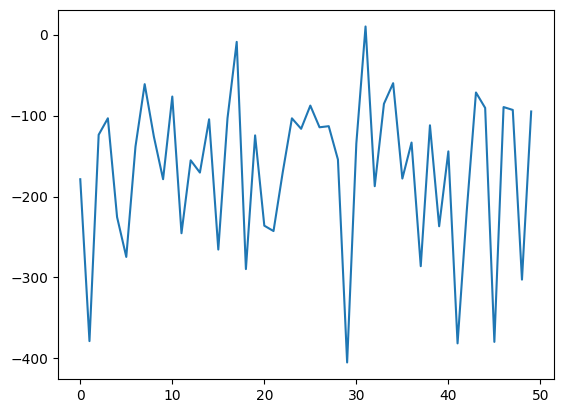


Recompensa de Media: -166.85856368207453 



In [110]:
# Evaluamos al Generador 
rewardMean=gan9.evaluate_G()
print('\nRecompensa de Media:', rewardMean, '\n')

## Experimento 10

In [111]:
expert_observations = np.genfromtxt("observations_LunarLander.csv",delimiter="\t",dtype=str)
expert_actions = np.genfromtxt('actions_LunarLander.csv', dtype=np.int32)
expert_num_tray=np.genfromtxt('n_trayectoria_LunarLander.csv', dtype=np.int32)

# Reemplazar las comas
expert_observations = np.core.defchararray.replace(expert_observations, ',', ' ')

# Crear un nuevo array para almacenar los datos convertidos
converted_observations = np.genfromtxt(expert_observations, delimiter=' ', dtype=float)

print("\n\tEstados reales: \n", converted_observations)
print("\tAcciones reales: \n", expert_actions)


	Estados reales: 
 [[-0.00655632  1.412633   -0.6640952  ...  0.15042743  0.
   0.        ]
 [-0.01301994  1.4137701  -0.65149987 ...  0.1017526   0.
   0.        ]
 [-0.01941118  1.414314   -0.6424104  ...  0.06514421  0.
   0.        ]
 ...
 [-0.46665245 -0.0082029   0.03071342 ...  0.67170596  1.
   1.        ]
 [-0.4661541  -0.01350838  0.02066027 ...  0.635882    1.
   1.        ]
 [-0.46567154 -0.01838761  0.02184356 ...  0.58443296  1.
   1.        ]]
	Acciones reales: 
 [3 3 3 ... 0 3 3]


In [112]:
longitud_trayectoria += np.count_nonzero(expert_num_tray == 9)
print(longitud_trayectoria)

6310


In [113]:
converted_observations=converted_observations[0:longitud_trayectoria]
expert_actions=expert_actions[0:longitud_trayectoria]

In [114]:
# Construimos el dataset [s,a] reales y lo dividimos en training y test
expert_a_one_hot=np.eye(env.action_space.n)[expert_actions]

dataset=np.concatenate([converted_observations,expert_a_one_hot],axis=1)


print(dataset)

# Divide los datos en conjuntos de entrenamiento y prueba
X_train, X_test = train_test_split(dataset, test_size=0.2, random_state=0)


#Imprime el número de elementos en el conjuntos de entrenamiento y prueba
print('Nº de (ESTADOS,ACCIONES) en el conjunto de entrenamiento:', len(X_train))
print('Nº de (ESTADOS,ACCIONES) en el conjunto de prueba:', len(X_test))

[[-0.00655632  1.412633   -0.6640952  ...  0.          0.
   1.        ]
 [-0.01301994  1.4137701  -0.65149987 ...  0.          0.
   1.        ]
 [-0.01941118  1.414314   -0.6424104  ...  0.          0.
   1.        ]
 ...
 [-0.46665245 -0.0082029   0.03071342 ...  0.          0.
   0.        ]
 [-0.4661541  -0.01350838  0.02066027 ...  0.          0.
   1.        ]
 [-0.46567154 -0.01838761  0.02184356 ...  0.          0.
   1.        ]]
Nº de (ESTADOS,ACCIONES) en el conjunto de entrenamiento: 5048
Nº de (ESTADOS,ACCIONES) en el conjunto de prueba: 1262


In [115]:
env= gym.make('LunarLander-v2')
obs,_= env.reset()

# Generador
generator=Policy_net( 'policy', env, obs)

# Generamos [s,a, s', r] falsas y las políticas theta_i y theta_i+1
observations, actions, rewards, Old_Policy, Policy=generator.generate_fakes()

# Discriminador
discriminator=Discriminator(env, discriminator_net, converted_observations, expert_actions, observations, actions)

### Definición de GAIL

In [116]:
gan10=GAN(discriminator=discriminator,generator=generator)

### Compilación de GAIL

In [117]:
tf.config.run_functions_eagerly(True)
gan10.compile(
    d_optimizer=tf.keras.optimizers.Adam(learning_rate=LEARNING_RATE),
    loss_fn_D=loss_fn_D
)

### Entrenamiento de GAIL

In [118]:
# Deshabilitar los mensajes de información de TensorFlow
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

# Deshabilitar los mensajes de información de OpenAI Gym
gym.logger.set_level(40)

BATCH_SIZE= round(len(X_train)/300)

history=gan10.fit(X_train,
    epochs=EPOCHS, batch_size=BATCH_SIZE)


297/297 [==============================] - 6157s 21s/step - d_loss: 1.8978 - g_loss: nan


### Evaluación de GAIL

In [119]:
# Evaluamos el Discriminador de GAIL en el TEST
gan10.evaluate_D(X_test)


1/1 [==============================] - 0s 33ms/step - loss: 0.0000e+00 - accuracy: 0.0000e+00
>Loss real: 
1.8892123976321784e-10
>Loss fake: 
0.0


Episode  0 Total reward: -386.4523198227279
Episode  1 Total reward: -136.7808737267269
Episode  2 Total reward: -125.85920807380852
Episode  3 Total reward: -267.24145157471514
Episode  4 Total reward: -188.48077658363252
Episode  5 Total reward: -263.28199187470966
Episode  6 Total reward: -99.1118090959776
Episode  7 Total reward: -301.5089989045374
Episode  8 Total reward: -77.12176852358067
Episode  9 Total reward: -116.85457814297884
Episode  10 Total reward: -127.0573651063143
Episode  11 Total reward: -100.41568618455973
Episode  12 Total reward: -127.9895235226383
Episode  13 Total reward: -345.30821658751483
Episode  14 Total reward: -316.2969178847669
Episode  15 Total reward: -334.5450765545045
Episode  16 Total reward: -73.50431666894715
Episode  17 Total reward: -308.2081221566156
Episode  18 Total reward: -98.47312526450371
Episode  19 Total reward: -309.58447410690246
Episode  20 Total reward: -60.964892258729336
Episode  21 Total reward: -153.82077741119764
Episode  22

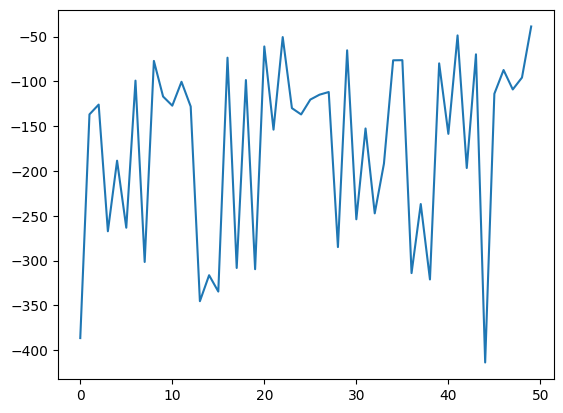


Recompensa de Media: -172.28956765574662 



In [120]:
# Evaluamos al Generador 
rewardMean=gan10.evaluate_G()
print('\nRecompensa de Media:', rewardMean, '\n')